In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import torch
from torchvision import transforms

In [2]:
csv_file = '/home/jovyan/work/hw_dataset/butterflies and moths.csv'
train_dir = '/home/jovyan/work/hw_dataset'
valid_dir = '/home/jovyan/work/hw_dataset'
test_dir = '/home/jovyan/work/hw_dataset'

In [3]:
df = pd.read_csv(csv_file)
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [4]:
num_classes = df['labels'].nunique()
print(f"Количество классов: {num_classes}")
print(f"Количество изображений в датасете: {len(df)}")

Количество классов: 100
Количество изображений в датасете: 13594


## Распределение классов

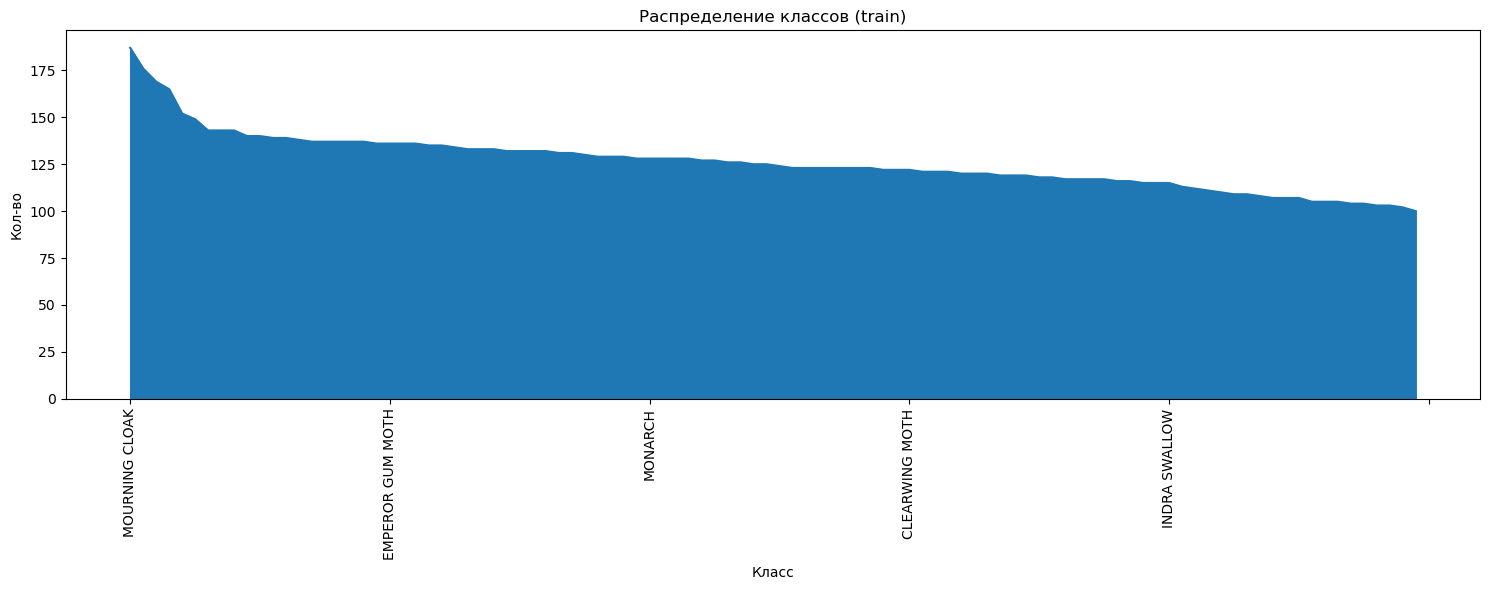

In [36]:
class_counts = df[df['data set'] == 'train']['labels'].value_counts()
plt.figure(figsize=(15, 6))
class_counts.plot(kind='area')
plt.title('Распределение классов (train)')
plt.xlabel('Класс')
plt.ylabel('Кол-во')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Часть классов содержит значительно больше изображений, чем другие. Это может привести к тому, что модель будет чаще предсказывать доминирующие классы и хуже справляться с менее представленными. Например, такие классы, как MOURNING CLOAK, имеют гораздо больше изображений по сравнению с другими классами, что повышает вероятность ошибок в предсказаниях последних.




## Экспериментальная. Часть 1

In [6]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 4.0 MB/s eta 0:00:00a 0:00:01


In [7]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 895.6 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.6 MB/s eta 0:00:0000:0100:01


In [8]:
import os
import torch
import torch.nn as nn
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassAUROC
from torchvision import models, transforms
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import timm

In [9]:
class ButterflyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ButterflyDataset(df[df['data set'] == 'train'], train_dir, transform=train_transform)
val_dataset = ButterflyDataset(df[df['data set'] == 'valid'], valid_dir, transform=val_test_transform)
test_dataset = ButterflyDataset(df[df['data set'] == 'test'], test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
def freeze_model_layers(model):
    for param in model.parameters():
        param.requires_grad = False

In [13]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:17<00:00, 10.5MB/s] 


In [14]:
efficientnet = models.efficientnet_b0(pretrained=True)
freeze_model_layers(efficientnet)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 100)
efficientnet = efficientnet.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 10.6MB/s]


In [15]:
densenet = models.densenet121(pretrained=True)
freeze_model_layers(densenet)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 100)
densenet = densenet.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 9.64MB/s]


In [16]:
vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=100)
freeze_model_layers(vit)
vit.head = nn.Linear(vit.head.in_features, 100)
vit = vit.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [17]:
swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=100)
freeze_model_layers(swin)
swin.head = nn.Linear(swin.head.in_features, 100)
swin = swin.to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [97]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def train_model(model, model_name, train_loader, val_loader, num_epochs = 10 ):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        train_labels, train_preds = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = outputs.max(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())

        
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, "
              f"Train Accuracy: {train_accuracy}, Train F1 Score: {train_f1}, "
              f"Train Precision: {train_precision}, Train Recall: {train_recall}")

        model.eval()
        val_labels, val_preds = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

            
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_precision = precision_score(val_labels, val_preds, average='weighted')
            val_recall = recall_score(val_labels, val_preds, average='weighted')

            print(f"Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}, "
                  f"Validation Precision: {val_precision}, Validation Recall: {val_recall}")
        print("-" * 50)

In [98]:
def evaluate_on_test_set(model, test_loader, model_name, results_df):
    model.eval()
    test_labels, test_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

   
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_precision = precision_score(test_labels, test_preds, average='weighted')
    test_recall = recall_score(test_labels, test_preds, average='weighted')

    
    return f"Test Accuracy: {test_accuracy}, Test F1 Score: {test_f1}, "f"Test Precision: {test_precision}, Test Recall: {test_recall}"

In [99]:
results_df = pd.DataFrame(columns=['Model', 'Test_Accuracy', 'Test_F1_Score', 'Test_ROC_AUC'])

In [100]:
train_model(resnet101, 'ResNet101', train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 0.4086250066757202, Train Accuracy: 0.8645386692075592, Train F1 Score: 0.8642010967091495, Train Precision: 0.8644814838930708, Train Recall: 0.8645386692075592


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.838, Validation F1 Score: 0.8267914307914308, Validation Precision: 0.8566150793650793, Validation Recall: 0.838
--------------------------------------------------
Epoch 2/10, Loss: 0.69435715675354, Train Accuracy: 0.890741622995077, Train F1 Score: 0.8906081104117137, Train Precision: 0.8907911233496476, Train Recall: 0.890741622995077
Validation Accuracy: 0.87, Validation F1 Score: 0.8649210005680594, Validation Precision: 0.8924761904761905, Validation Recall: 0.87
--------------------------------------------------
Epoch 3/10, Loss: 0.1792808473110199, Train Accuracy: 0.9020962363030014, Train F1 Score: 0.9018184661817158, Train Precision: 0.9019083464625207, Train Recall: 0.9020962363030014
Validation Accuracy: 0.87, Validation F1 Score: 0.8647188133503925, Validation Precision: 0.8988466810966812, Validation Recall: 0.87
--------------------------------------------------
Epoch 4/10, Loss: 0.2610032558441162, Train Accuracy: 0.9103541368905829, Train F1 Scor

In [102]:
train_model(efficientnet, 'EfficientNet-B0', train_loader, val_loader, num_epochs=5)

Epoch 1/5, Loss: 1.1920084953308105, Train Accuracy: 0.6781800857551215, Train F1 Score: 0.6788986969202355, Train Precision: 0.6960806956531472, Train Recall: 0.6781800857551215
Validation Accuracy: 0.846, Validation F1 Score: 0.8400382950382951, Validation Precision: 0.858452380952381, Validation Recall: 0.846
--------------------------------------------------
Epoch 2/5, Loss: 0.713265597820282, Train Accuracy: 0.8535810703509608, Train F1 Score: 0.8529823860368438, Train Precision: 0.8544104637713329, Train Recall: 0.8535810703509608
Validation Accuracy: 0.882, Validation F1 Score: 0.8756266511266512, Validation Precision: 0.8842023809523811, Validation Recall: 0.882
--------------------------------------------------
Epoch 3/5, Loss: 0.4766036570072174, Train Accuracy: 0.8792282039066222, Train F1 Score: 0.8787748093331342, Train Precision: 0.8795217498377772, Train Recall: 0.8792282039066222
Validation Accuracy: 0.908, Validation F1 Score: 0.9038686868686869, Validation Precision: 

In [103]:
train_model(densenet, 'DenseNet121', train_loader, val_loader, num_epochs=5)

Epoch 1/5, Loss: 1.0622202157974243, Train Accuracy: 0.6348261076703192, Train F1 Score: 0.6364108437979562, Train Precision: 0.6510420675941893, Train Recall: 0.6348261076703192


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.834, Validation F1 Score: 0.8279087154675391, Validation Precision: 0.8560178571428572, Validation Recall: 0.834
--------------------------------------------------
Epoch 2/5, Loss: 0.48653650283813477, Train Accuracy: 0.8767667143084008, Train F1 Score: 0.876572843093113, Train Precision: 0.8777839194893868, Train Recall: 0.8767667143084008
Validation Accuracy: 0.902, Validation F1 Score: 0.900007215007215, Validation Precision: 0.9122619047619048, Validation Recall: 0.902
--------------------------------------------------
Epoch 3/5, Loss: 0.27712294459342957, Train Accuracy: 0.9064633952675878, Train F1 Score: 0.9061607911361476, Train Precision: 0.9069519139926803, Train Recall: 0.9064633952675878
Validation Accuracy: 0.914, Validation F1 Score: 0.9111685536685536, Validation Precision: 0.933234126984127, Validation Recall: 0.914
--------------------------------------------------
Epoch 4/5, Loss: 0.18050642311573029, Train Accuracy: 0.919326663490551, Train F1 

In [104]:
train_model(vit, 'ViT', train_loader, val_loader, num_epochs=5)

Epoch 1/5, Loss: 0.4435622990131378, Train Accuracy: 0.7912498014927744, Train F1 Score: 0.7914664174959971, Train Precision: 0.7968016375209868, Train Recall: 0.7912498014927744


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.916, Validation F1 Score: 0.9079632589632589, Validation Precision: 0.9286031746031745, Validation Recall: 0.916
--------------------------------------------------
Epoch 2/5, Loss: 0.3138807415962219, Train Accuracy: 0.9307606796887407, Train F1 Score: 0.9305461131659243, Train Precision: 0.9308063875170275, Train Recall: 0.9307606796887407
Validation Accuracy: 0.948, Validation F1 Score: 0.9468282828282828, Validation Precision: 0.9567380952380953, Validation Recall: 0.948
--------------------------------------------------
Epoch 3/5, Loss: 0.1805182546377182, Train Accuracy: 0.9487851357789423, Train F1 Score: 0.948714835124877, Train Precision: 0.9488788027251783, Train Recall: 0.9487851357789423


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.946, Validation F1 Score: 0.9410963480963482, Validation Precision: 0.9463928571428573, Validation Recall: 0.946
--------------------------------------------------
Epoch 4/5, Loss: 0.21368396282196045, Train Accuracy: 0.9586310941718279, Train F1 Score: 0.9585730703050509, Train Precision: 0.9587782719443884, Train Recall: 0.9586310941718279
Validation Accuracy: 0.964, Validation F1 Score: 0.9623182373182373, Validation Precision: 0.973452380952381, Validation Recall: 0.964
--------------------------------------------------
Epoch 5/5, Loss: 0.18222008645534515, Train Accuracy: 0.9622042242337621, Train F1 Score: 0.9621542508384737, Train Precision: 0.9623130244902406, Train Recall: 0.9622042242337621
Validation Accuracy: 0.954, Validation F1 Score: 0.9525627705627706, Validation Precision: 0.9617619047619048, Validation Recall: 0.954
--------------------------------------------------


In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
def train_resnet101_experiment(optimizer_name, optimizer, lr, scheduler_step, scheduler_gamma, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(resnet101.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
    f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
    auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

    for epoch in range(num_epochs):
        resnet101.train()
        running_loss = 0.0
        accuracy_metric.reset()
        f1_metric.reset()
        auroc_metric.reset()

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = resnet101(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)

                accuracy_metric.update(preds, labels)
                f1_metric.update(preds, labels)
                auroc_metric.update(outputs.softmax(dim=-1), labels)

                train_acc = accuracy_metric.compute()
                train_f1 = f1_metric.compute()
                train_auroc = auroc_metric.compute()

                tepoch.set_postfix(loss=running_loss / len(train_loader), accuracy=train_acc.item(), f1=train_f1.item(), roc_auc=train_auroc.item())

        scheduler.step()

        resnet101.eval()
        val_accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
        val_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
        val_auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet101(inputs)
                preds = torch.argmax(outputs, dim=1)

                val_accuracy_metric.update(preds, labels)
                val_f1_metric.update(preds, labels)
                val_auroc_metric.update(outputs.softmax(dim=-1), labels)

        val_acc = val_accuracy_metric.compute()
        val_f1 = val_f1_metric.compute()
        val_auroc = val_auroc_metric.compute()

        print(f"Validation - Epoch {epoch+1}: Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, ROC AUC: {val_auroc:.4f}")

In [ ]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_Adam_0.001', results_df)
print(results_df)

In [ ]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.01, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_Adam_0.01', results_df)
print(results_df)

In [ ]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('SGD', SGD, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_SGD_0.001', results_df)
print(results_df)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ButterflyDataset(df[df['data set'] == 'train'], train_dir, transform=train_transform)
val_dataset = ButterflyDataset(df[df['data set'] == 'valid'], valid_dir, transform=val_test_transform)
test_dataset = ButterflyDataset(df[df['data set'] == 'test'], test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_with_add_augmentation', results_df)
print(results_df)

In [ ]:
results_df.to_csv('results.csv', index=False)